In [176]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following code will download the EuroSAT dataset RGB version.

In [177]:
import os
from pytorch_eo.utils import download_url, unzip_file
from pathlib import Path

path = Path('data')
os.makedirs(path, exist_ok=True)

url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
compressed_data_filename = 'EuroSAT.zip'
compressed_data_path = path / compressed_data_filename
download_url(url, compressed_data_path)

unzip_file(compressed_data_path, path, msg="extracting data ...")

extracting data ...: 100%|██████████| 27011/27011 [00:02<00:00, 11895.44it/s]


Now we can find our images and labels. Each dataset may have its own pre-processing steps, in this case the labels are encoded in the folder name and images can be find inside each folder.

In [178]:
data_folder = '2750'
uncompressed_data_path = path / data_folder
classes = sorted(os.listdir(uncompressed_data_path))
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [179]:
import pandas as pd

images, labels = [], []
for ix, label in enumerate(classes):
    _images = os.listdir(uncompressed_data_path / label)
    images += [uncompressed_data_path /
                label / img for img in _images]
    labels += [ix]*len(_images)

df = pd.DataFrame({'image': images, 'label': labels})

df.sample(5)

,image,label
5522,data/2750/Forest/Forest_517.jpg,1
23997,data/2750/River/River_795.jpg,8
2877,data/2750/AnnualCrop/AnnualCrop_1419.jpg,0
10788,data/2750/Highway/Highway_1434.jpg,3
4348,data/2750/Forest/Forest_442.jpg,1


Nevertheless, we will always end up with the same: a list of paths to images and the corresponding labels (or bounding boxes, segmentation masks, ...), pairs of inputs-outputs to feed and train our model.

## Data splits

The first thing that we need is to split our data in train and test. This is important for reproducibility (comparing our results to others) as long as we use the same splits. Sometimes this splits will already be provided, in this case we build them ourselves. 

Additionally, we may want to use a validation split for hyperparameter optimization. The approach we take in pytorch EO is to have all our data in one Dataframe and then provide the indices to be used for train-test-validation. This simplifies our lives when defining different validation strategies (no validation, validation with a subset or cross validation). If train-test-validation splits are provided to you, first make sure to merge all the data in one Dataframe.

First, we need a dataset.

In [180]:
from pytorch_eo.utils.datasets.ClassificationDataset import ClassificationDataset

ds = ClassificationDataset(images, labels)

len(ds)

27000

The dataset will contain all the available samples.

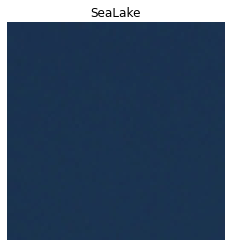

In [181]:
import random 
import matplotlib.pyplot as plt

ix = random.randint(0, len(ds)-1)

img, label = ds[ix]

fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(img.permute(1,2,0))
ax.set_title(classes[label.item()])
ax.axis('off')
plt.show()

In order to train a model, we will need a DataLoader. This is the objet responsible for efficiently loading data and batching it. It is at this point when we split the data into train-validation-test, by providing a `Sampler`. 

In [182]:
from torch.utils.data import DataLoader, SequentialSampler

sampler = SequentialSampler([0, 1, 2])

len(sampler)

3

In [183]:
# this will always return the first 3 images in the dataset

dl = DataLoader(ds, batch_size=3, sampler=sampler)

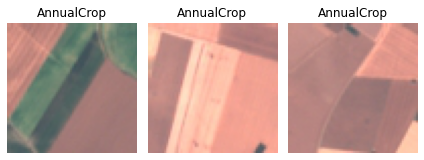

In [184]:
def plot_batch(batch):
    imgs, labels = batch
    fig = plt.figure()
    for ix, (img, label) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(1,len(imgs), ix + 1)
        ax.imshow(img.permute(1,2,0))
        ax.set_title(classes[label.item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

batch = next(iter(dl))
plot_batch(batch)

In [185]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# this will always return the first 3 images randomly

sampler = SubsetRandomSampler([0, 1, 2])
dl = DataLoader(ds, batch_size=3, sampler=sampler)

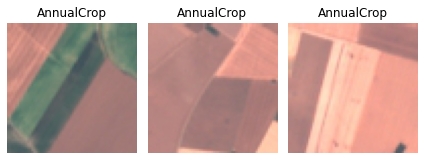

In [186]:
batch = next(iter(dl))
plot_batch(batch)

Checkout available samplers [here](https://pytorch.org/docs/stable/data.html).

### Train-Test splits

In [187]:
test_size = 0.2 # use 20% of the data for testing
idxs = list(range(len(ds)))
testset_len = int(len(ds)*test_size)
trainset_len = len(ds) - testset_len

trainset_len, testset_len

(21600, 5400)

Use last 20% of the data for testing

In [199]:
train_idxs = idxs[:trainset_len]
test_idxs = idxs[trainset_len:]

len(train_idxs), len(test_idxs)

(21600, 5400)

This can be problematic in some cases (unbalanced class distributions)

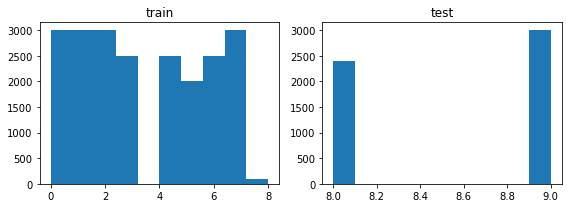

In [200]:
def plot_class_balance(train_idxs, test_idxs):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(1,2,1)
    ax.hist(np.array(labels)[train_idxs], bins=len(classes))
    ax.set_title('train')
    ax = plt.subplot(1,2,2)
    ax.hist(np.array(labels)[test_idxs], bins=len(classes))
    ax.set_title('test')
    plt.tight_layout()
    plt.show()

plot_class_balance(train_idxs, test_idxs)

Better to random split given size and a seed (use same size and seed to compare with others).

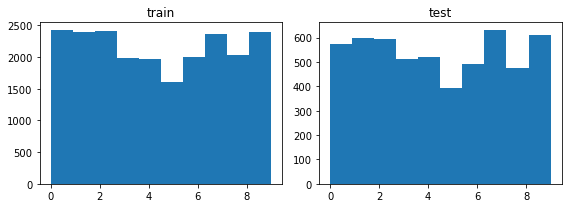

In [201]:
# using numpy

import numpy as np

np.random.shuffle(idxs)

train_idxs = idxs[:trainset_len]
test_idxs = idxs[trainset_len:]

plot_class_balance(train_idxs, test_idxs)

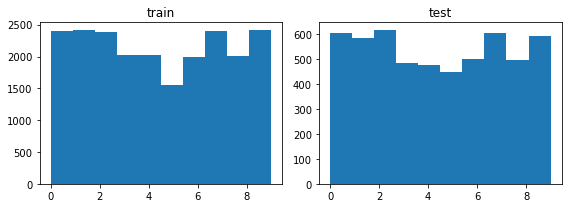

In [202]:
# using pytorch

import torch
from torch.utils.data import random_split

seed = 42
train_idxs, test_idxs = random_split(idxs, [trainset_len, testset_len], generator=torch.Generator().manual_seed(seed))

plot_class_balance(train_idxs, test_idxs)

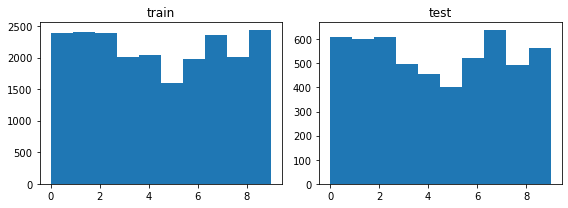

In [205]:
# or better yet, stratify by label

from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(idxs, test_size=test_size, shuffle=True, stratify=labels, random_state=seed)

plot_class_balance(train_idxs, test_idxs)

### Validation split

Use a subset of training data

In [207]:
val_size = 0.2 # use 20% of the training data for validating
idxs = list(range(len(ds)))
valset_len = int(len(ds)*val_size)
trainset2_len = trainset_len - valset_len

trainset2_len, valset_len, testset_len

(16200, 5400, 5400)

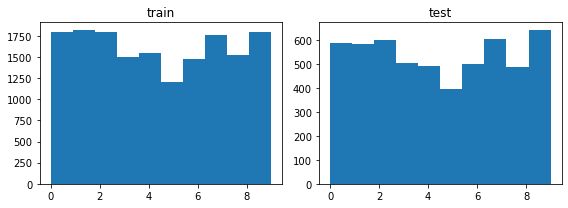

In [209]:
seed = 42
train2_idxs, val_idxs = random_split(train_idxs, [trainset2_len, valset_len], generator=torch.Generator().manual_seed(seed))

plot_class_balance(train2_idxs, val_idxs)

Or use cross validation

In [215]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
skf.get_n_splits(idxs)

5

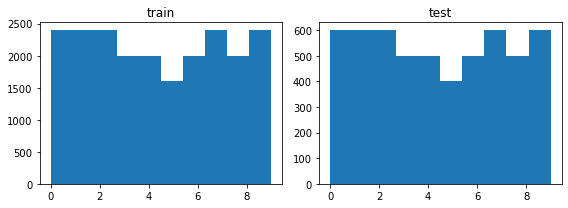

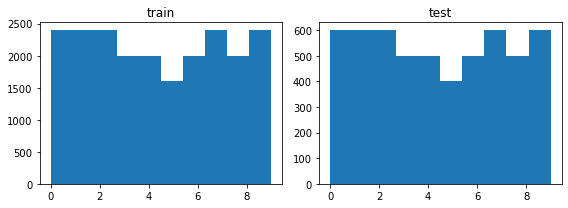

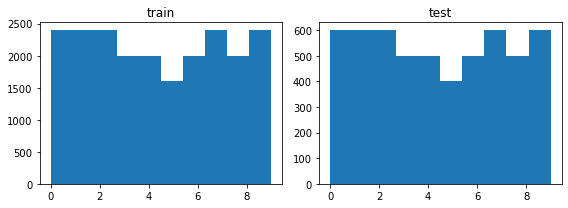

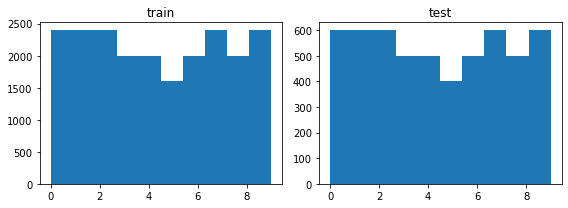

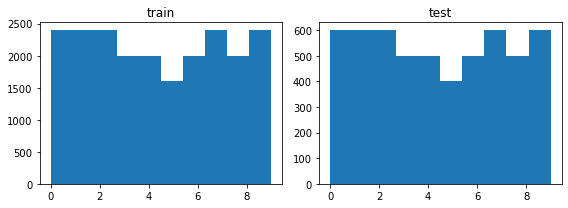

In [216]:
for train_index, val_index in skf.split(idxs, labels):
    plot_class_balance(train_index, val_index)

## Conclusions

In this tutorial we have shown you how data loading works in Pytorch EO. The main ideas to have keep in mind are:

1. Gather all your data into one Dataframe (in case train-val-test splits are provided)
2. Build one dataset for all the data
3. Compute list of indices for each split (train-val-test). Use your favorite method here, we default to `Pytorch`.
3. Define one DataLoader per split using `Samplers` to define the data used in the split.